In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
from sklearn import datasets
import scipy
from matplotlib.colors import ListedColormap
from functools import partial

In [2]:
np.random.seed(5)               # Set the random seed.

In [3]:
datasets = {0:'tic_tac',1:'adult',2:'cloud',3:'my_dota',4:'uci_data'}
# choses via random dieroll
random_seeds = [3,6,1,5,2,2,1,5,2,6]

In [4]:
cloud_data = pd.read_pickle("./data/cloud_data_sample.pkl")  

In [5]:
cloud_data = cloud_data.sample(n=500, random_state=22)

In [6]:
uci_dota = pd.read_pickle("./data/uci_dota_sample.pkl")  
uci_dota = uci_dota.sample(n=500, random_state=22)

In [7]:
my_dota = pd.read_pickle("./data/my_dota.pkl")  
my_dota = my_dota.sample(n=500, random_state=22)

In [8]:
adult_data = pd.read_csv("./data/adult_data.csv")    
adult_data['class'] = adult_data['class'].where(adult_data['class'] == adult_data['class'][0], 1)
adult_data['class'] = adult_data['class'].where(adult_data['class'] == 1, -1)
adult_data= adult_data.sample(n=500, random_state=22)

In [9]:
tic_tac_data = pd.read_pickle("./data/tic_tac_data.pkl")  
tic_tac_data.head()

,x_won,t_l_b,t_l_o,t_l_x,t_m_b,t_m_o,t_m_x,t_r_b,t_r_o,t_r_x,...,m_r_x,b_l_b,b_l_o,b_l_x,b_m_b,b_m_o,b_m_x,b_r_b,b_r_o,b_r_x
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [10]:
X = []
X.append(tic_tac_data.drop(columns='x_won'))
X.append(adult_data.drop(columns='class'))
X.append(cloud_data.drop(columns='binary_class'))
X.append(my_dota.drop(columns='team_won'))
X.append(uci_dota.drop(columns='team_won'))


In [11]:
Y = []
Y.append(tic_tac_data['x_won'].values.reshape(-1,1).astype(np.float))
Y.append(adult_data['class'].values.reshape(-1,1).astype(np.float))
Y.append(cloud_data['binary_class'].values.reshape(-1,1).astype(np.float))
Y.append(my_dota['team_won'].values.reshape(-1,1).astype(np.float))
Y.append(uci_dota['team_won'].values.reshape(-1,1).astype(np.float))

In [12]:
def get_random_train_test(prop_test):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    
    for i in datasets.keys():
       # print()
        X_and_Y = np.hstack((X[i], Y[i]))     # Stack them together for shuffling.
        np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

        #print(datasets[i])
       # print('X', X[i].shape)
       # print('Y', Y[i].shape)
        
        X_shuffled = X_and_Y[:,:-1]
        Y_shuffled = X_and_Y[:,-1]
        
        pivot = int(X[i].shape[0]*(1-prop_test))
        X_train.append(X_shuffled[:pivot]) 
        Y_train.append(Y_shuffled[:pivot])             
        X_test.append(X_shuffled[pivot:]) 
        Y_test.append(Y_shuffled[pivot:])
        
       # print('X_train', X_train[i].shape)
       # print('Y_train', Y_train[i].shape)
        
       # print('X_test', X_test[i].shape)
       # print('Y_test', Y_test[i].shape)
        
    return X_train, Y_train, X_test, Y_test

    

In [13]:
import math
import seaborn as sns       
import numbers
import copy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


cv_num = 3

In [14]:
def plot_grid_search_validation_curve(grid, param_to_vary,
                                      title='Validation Curve', ylim=None,
                                      xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')

    plt.show()

In [15]:


# Calculate error given feature vectors X and labels Y.
def calc_error(Y_pred, Y):
    return np.array(y_predicted !=  Y_test[0]).astype(np.float32).mean()

In [16]:
#KNN model
pipe_knn = Pipeline([
    ('sc', StandardScaler()),     
    ('knn', KNeighborsClassifier()) 
])
k_max = 10

def get_knn_parm(n):
    step = math.log((n / cv_num) * (cv_num-1) ,k_max)
    return {'knn__n_neighbors': np.power(np.arange(1,k_max), step).astype(int), 'knn__p' : [1, 2,3]}


In [17]:
# SVM model
pipe_svm = Pipeline([
    ('sc', StandardScaler()),     
    ('svm', SVC()) 
])

def get_svm_parm(n):
    return {'svm__C': [10**c for c in np.arange(-7,3, dtype=float)], 'svm__kernel' : ['linear','rbf']}

In [45]:

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [59]:
[2**c *  for c in np.arange(-1,4, dtype=float)]

[2.5, 5.0, 10.0, 20.0, 40.0]

In [106]:
# Random forest model
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier()) 
])

# used https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
# to get reasonble RF hyperparmeters then changed it to match http://lowrank.net/nikos/pubs/empirical.pdf
def get_rv_parm(n):
    s = int(n**0.5)
    n_estimators = [2**c for c in np.arange(7,13, dtype=int)]
    max_features = ['auto', 'sqrt']
    min_samples_split = [2**c * s for c in np.arange(-1,4, dtype=float)]
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'rf__n_estimators': n_estimators,
                   'rf__max_features': max_features,
                   'rf__min_samples_split': min_samples_split,
                   'rf__bootstrap': bootstrap}
    return random_grid

In [107]:
classifiers = {'KNN' : 
                    {'pipe' : pipe_knn, 'params' : get_knn_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]},
                'SVM' : 
                   {'pipe' : pipe_svm, 'params' : get_svm_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]},
               'RF' :
                    {'pipe' : pipe_rf, 'params' : get_rv_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]}
              }
            


In [108]:
def train(x,y, model):
    clf = RandomizedSearchCV(estimator=model['pipe'],n_iter = 15,           
                  param_distributions=model['params'](x.shape[0]), 
                  cv=cv_num,
                  return_train_score=True,n_jobs=5, pre_dispatch = '2*n_jobs',  refit=True,scoring = 'accuracy')

    return clf.fit(x, y)

In [109]:
def test(x_test,y_test, model):
    y_pred  = model.predict(x_test)
    return accuracy_score(y_pred,y_test)
    

In [110]:
dict = copy.deepcopy(dict)

In [111]:
partions = [0.2,0.5,0.8]

In [112]:
def new_results_dic(partions, datasets, classifiers):
    results_dic = {}
    for i, part in enumerate(partions, start=0):
        results_dic[i] = {'partion' : part, 'datasets':{}}
        for dataset in datasets.items():
            results_dic[i]['datasets'][dataset[1]] = {'index' : dataset[0], 'classifiers':copy.deepcopy(classifiers)}
    return results_dic
        
    

In [103]:
def update_avrg_auc_over_n_trials(n, results_dic):
    
    for i in range(0,n):
        print('\ttrial', i)
        X_train, Y_train, X_test, Y_test = get_random_train_test(results_dic['partion'])
        for dataset in results_dic['datasets']:
            print('\t\tdataset', dataset)
            dataset = results_dic['datasets'][dataset]
            for classifier in dataset['classifiers']:
                print('\t\t\ttunning ', classifier)
                classifier = dataset['classifiers'][classifier]
                grid = train(X_train[dataset['index']],Y_train[dataset['index']], classifier)
                classifier['test_auc'].append(test(X_test[dataset['index']], Y_test[dataset['index']],grid))
                classifier['train_auc'].append(grid.cv_results_['mean_train_score'][grid.best_index_])
                classifier['val_auc'].append(grid.cv_results_['mean_test_score'][grid.best_index_])

                classifier['grid_list'].append(grid)
    
        

In [104]:
def run_core_loop():
    results_dic = new_results_dic(partions, datasets, classifiers)
    for part in results_dic.values():
        print('partion', part['partion'])
        update_avrg_auc_over_n_trials(3, part)
    return results_dic
        

In [105]:
results_dic = run_core_loop()

partion 0.2
	trial 0
		dataset tic_tac
			tunning  KNN
			tunning  SVM
			tunning  RF


ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the float 13.838352503098047

In [28]:
def get_part_str(part):
    return ' partion_' + str(int(round((100*(1-part['partion']))))) + '/' +str(int(round((100*part['partion'])))) + ' '

In [29]:
classifiers.keys()

dict_keys(['KNN', 'SVM'])

In [30]:
columns = [ classifier + get_part_str(part) + auc for classifier in classifiers.keys() for part in results_dic.values() for auc in ['test_auc','train_auc','val_auc'] ]
columns += ([classifier+ ' mean ' + auc for classifier in classifiers.keys() for auc in ['test_auc','train_auc','val_auc']])

In [31]:
from statistics import mean 


In [32]:
final_summery = pd.DataFrame(columns=columns, index=results_dic[0]['datasets'].keys())
final_summery.columns

Index(['KNN partion_80/20 test_auc', 'KNN partion_80/20 train_auc',
       'KNN partion_80/20 val_auc', 'KNN partion_50/50 test_auc',
       'KNN partion_50/50 train_auc', 'KNN partion_50/50 val_auc',
       'KNN partion_20/80 test_auc', 'KNN partion_20/80 train_auc',
       'KNN partion_20/80 val_auc', 'SVM partion_80/20 test_auc',
       'SVM partion_80/20 train_auc', 'SVM partion_80/20 val_auc',
       'SVM partion_50/50 test_auc', 'SVM partion_50/50 train_auc',
       'SVM partion_50/50 val_auc', 'SVM partion_20/80 test_auc',
       'SVM partion_20/80 train_auc', 'SVM partion_20/80 val_auc',
       'KNN mean test_auc', 'KNN mean train_auc', 'KNN mean val_auc',
       'SVM mean test_auc', 'SVM mean train_auc', 'SVM mean val_auc'],
      dtype='object')

In [33]:
final_summery

,KNN partion_80/20 test_auc,KNN partion_80/20 train_auc,KNN partion_80/20 val_auc,KNN partion_50/50 test_auc,KNN partion_50/50 train_auc,KNN partion_50/50 val_auc,KNN partion_20/80 test_auc,KNN partion_20/80 train_auc,KNN partion_20/80 val_auc,SVM partion_80/20 test_auc,...,SVM partion_50/50 val_auc,SVM partion_20/80 test_auc,SVM partion_20/80 train_auc,SVM partion_20/80 val_auc,KNN mean test_auc,KNN mean train_auc,KNN mean val_auc,SVM mean test_auc,SVM mean train_auc,SVM mean val_auc
tic_tac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cloud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
my_dota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uci_data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
avreges_names = ([classifier+ ' mean ' + auc for classifier in classifiers.keys() for auc in ['test_auc','train_auc','val_auc']])

In [35]:
for part in results_dic.values():
    for dataset in part['datasets']:
        row = final_summery.loc[dataset]
        dataset = part['datasets'][dataset]
        for classifier in dataset['classifiers']:
            columns_head = classifier + get_part_str(part)
            classifier = dataset['classifiers'][classifier]
            row[columns_head + 'test_auc'] = mean(classifier['test_auc'])
            row[columns_head + 'train_auc'] = mean(classifier['train_auc'])
            row[columns_head + 'val_auc'] = mean(classifier['val_auc'])
            
        for name in avreges_names:
            row[name] = row.filter(regex='^'+name.split()[0]+'.*partion_.*' + name.split()[2]).mean()


In [36]:
([classifier+ ' mean ' + auc for classifier in classifiers.keys() for auc in ['test_auc','train_auc','val_auc']])

['KNN mean test_auc',
 'KNN mean train_auc',
 'KNN mean val_auc',
 'SVM mean test_auc',
 'SVM mean train_auc',
 'SVM mean val_auc']

In [37]:
final_summery.loc['tic_tac'].filter(regex='^KNN.*test_auc').mean()

0.7656018388095057

In [38]:
final_summery

,KNN partion_80/20 test_auc,KNN partion_80/20 train_auc,KNN partion_80/20 val_auc,KNN partion_50/50 test_auc,KNN partion_50/50 train_auc,KNN partion_50/50 val_auc,KNN partion_20/80 test_auc,KNN partion_20/80 train_auc,KNN partion_20/80 val_auc,SVM partion_80/20 test_auc,...,SVM partion_50/50 val_auc,SVM partion_20/80 test_auc,SVM partion_20/80 train_auc,SVM partion_20/80 val_auc,KNN mean test_auc,KNN mean train_auc,KNN mean val_auc,SVM mean test_auc,SVM mean train_auc,SVM mean val_auc
tic_tac,0.769097,0.846173,0.799357,0.809325,0.885517,0.807272,0.718383,0.939797,0.738261,0.991319,...,0.869855,0.97827,0.989529,0.979084,0.765602,0.890496,0.78163,0.954373,0.953862,0.943553
adult,0.706667,0.761661,0.760016,0.761333,0.749341,0.748024,0.746467,0.757576,0.760943,0.72,...,0.748008,0.751455,0.754209,0.754209,0.738156,0.756192,0.756327,0.742485,0.765599,0.753793
cloud,0.726667,0.791673,0.76837,0.752,0.765313,0.746574,0.730673,0.791246,0.757576,0.75,...,0.799994,0.783042,0.880471,0.801347,0.736447,0.782744,0.757506,0.777681,0.844401,0.810168
my_dota,0.456667,0.720842,0.545001,0.494667,0.592622,0.528017,0.488778,0.560606,0.535354,0.506667,...,0.530662,0.493766,0.676768,0.538721,0.480037,0.62469,0.536124,0.510366,0.888897,0.545356
uci_data,0.5,0.599572,0.52664,0.493333,0.710707,0.548017,0.485453,0.648148,0.579125,0.53,...,0.540033,0.490441,0.989899,0.558923,0.492929,0.652809,0.551261,0.502369,0.864303,0.541312


In [39]:
final_summery.filter(regex='^SVM mean .*').mean()

SVM mean test_auc     0.697455
SVM mean train_auc    0.863412
SVM mean val_auc      0.718836
dtype: float64

In [40]:
final_summery[[c for c in columns if 'test_auc' in c]]

,KNN partion_80/20 test_auc,KNN partion_50/50 test_auc,KNN partion_20/80 test_auc,SVM partion_80/20 test_auc,SVM partion_50/50 test_auc,SVM partion_20/80 test_auc,KNN mean test_auc,SVM mean test_auc
tic_tac,0.769097,0.809325,0.718383,0.991319,0.893528,0.97827,0.765602,0.954373
adult,0.706667,0.761333,0.746467,0.72,0.756,0.751455,0.738156,0.742485
cloud,0.726667,0.752,0.730673,0.75,0.8,0.783042,0.736447,0.777681
my_dota,0.456667,0.494667,0.488778,0.506667,0.530667,0.493766,0.480037,0.510366
uci_data,0.5,0.493333,0.485453,0.53,0.486667,0.490441,0.492929,0.502369


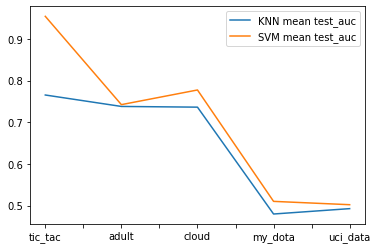

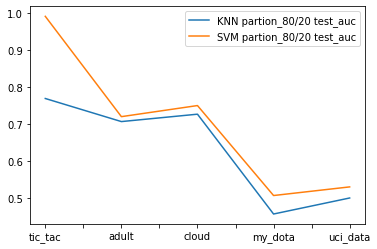

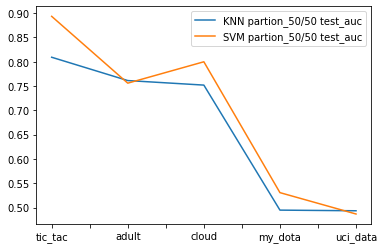

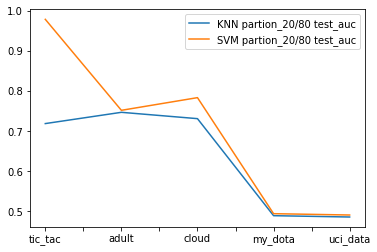

In [43]:
final_summery[[c for c in columns if 'mean test_auc' in c]].plot(subplots=False)
final_summery[[c for c in columns if 'partion_80/20 test_auc' in c]].plot(subplots=False)
final_summery[[c for c in columns if 'partion_50/50 test_auc' in c]].plot(subplots=False)
final_summery[[c for c in columns if 'partion_20/80 test_auc' in c]].plot(subplots=False)


In [42]:
#plot_grid_search_validation_curve(grid, 'knn__p', log=False, ylim=(.4, 1.02))
#plot_grid_search_validation_curve(grid, 'knn__n_neighbors', log=True, ylim=(.4, 1.02))
#parm = classifiers['KNN']['params'](X_train[0].shape[0])
#scores = grid.cv_results_['mean_test_score'].reshape(len(parm['knn__n_neighbors']),len(parm['knn__p']))
#ax = sns.heatmap(scores